# GAN

### 导入依赖
导入 PyTorch 相关的库和模块，用于构建和训练神经网络。
导入数据加载和变换工具，以及 CIFAR-10 数据集。

In [ ]:
import torch.nn as nn
import torch.nn.init as init
import torch
import torch.optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

### 网络结构设置
latent_size: 隐向量的大小，生成器的输入尺寸。
n_channel: 图像的通道数，对于 CIFAR-10 是 3（RGB）。
n_g_feature, n_d_feature: 生成器和判别器的特征数量。

In [18]:
latent_size = 64
n_channel = 3
n_g_feature = 64
n_d_feature = 64

### 生成器（Generator）
使用 nn.ConvTranspose2d 构建反卷积层，用于从隐向量生成图像。
通过批量归一化（nn.BatchNorm2d）和激活函数（nn.ReLU）改善训练过程。
最后一层使用 nn.Sigmoid，因为图像像素值在 [0,1] 范围内。

In [19]:
gnet = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 4 * n_g_feature, kernel_size=4, bias=False),
    nn.BatchNorm2d(4 * n_g_feature),
    nn.ReLU(),

    nn.ConvTranspose2d(4 * n_g_feature, 2 * n_g_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2 * n_g_feature),
    nn.ReLU(),

    nn.ConvTranspose2d(2 * n_g_feature, n_g_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(n_g_feature),
    nn.ReLU(),

    nn.ConvTranspose2d(n_g_feature, n_channel, kernel_size=4, stride=2, padding=1),
    nn.Sigmoid()
)

### 判别器（Discriminator）
使用 nn.Conv2d 构建卷积层，用于将图像分类为真或假。
使用 nn.LeakyReLU 作为激活函数。
最后一层输出一个标量，表示图像为真的概率。

In [20]:
dnet = nn.Sequential(
    nn.Conv2d(n_channel, n_d_feature, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2),

    nn.Conv2d(n_d_feature, 2 * n_d_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2 * n_d_feature),
    nn.LeakyReLU(0.2),

    nn.Conv2d(2 * n_d_feature, 4 * n_d_feature, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4 * n_d_feature),
    nn.LeakyReLU(0.2),

    nn.Conv2d(4 * n_d_feature, 1, kernel_size=4)
)

### 权重初始化
使用 weights_init 函数来初始化网络权重，这有助于更好的训练。

In [21]:
def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)


gnet.apply(weights_init)
dnet.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)

### 数据加载
加载 CIFAR-10 数据集并应用变换。
使用 DataLoader 进行批处理和洗牌。

In [22]:
dataset = CIFAR10(root='./CIFARdata', download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


### 损失函数和优化器
使用二元交叉熵损失（BCEWithLogitsLoss）。
为生成器和判别器分别设置 Adam 优化器。
训练过程

In [23]:
criterion = nn.BCEWithLogitsLoss()
goptimizer = torch.optim.Adam(gnet.parameters(), lr=0.0002, betas=(0.5, 0.999))
doptimizer = torch.optim.Adam(dnet.parameters(), lr=0.0002, betas=(0.5, 0.999))

### 训练过程
迭代指定的次数（epoch_num）。
对每个批次的真实图像和生成的假图像计算损失。
更新判别器和生成器的权重。
每100个批次保存生成的图像。

Epoch index: 0, 1 epoches in total.
Batch index: 0, the batch size is 64.
Discriminator loss is: 2.0131707191467285, generator loss is: 3.719346761703491 
 Discriminator tells real images real ability: 0.5422301292419434 
 Discriminator tells fake images real ability: 0.715784/0.027083
Epoch index: 0, 1 epoches in total.
Batch index: 100, the batch size is 64.
Discriminator loss is: 0.1933995634317398, generator loss is: 2.685181140899658 
 Discriminator tells real images real ability: 0.8877425789833069 
 Discriminator tells fake images real ability: 0.0668366/0.0809524
Epoch index: 0, 1 epoches in total.
Batch index: 200, the batch size is 64.
Discriminator loss is: 0.4867536127567291, generator loss is: 3.9829626083374023 
 Discriminator tells real images real ability: 0.8986188769340515 
 Discriminator tells fake images real ability: 0.281993/0.0269879
Epoch index: 0, 1 epoches in total.
Batch index: 300, the batch size is 64.
Discriminator loss is: 0.3327685296535492, generator lo

D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Anaconda3\lib\site-packages\IPython\core\pylabt

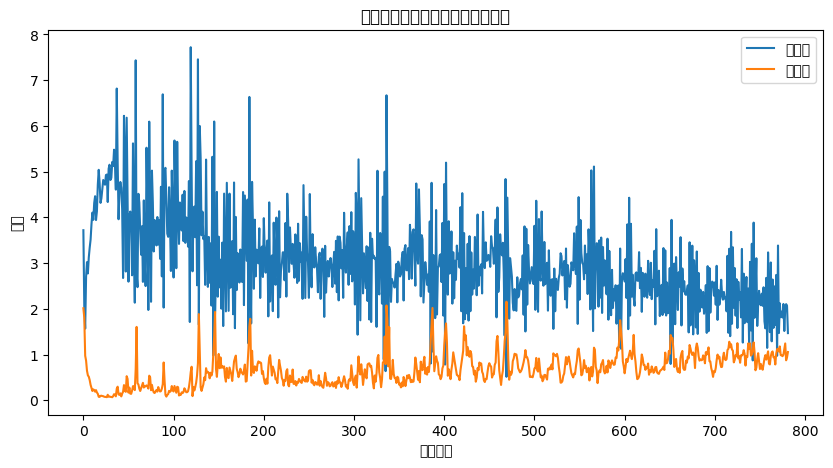

In [24]:
batch_size = 64
fixed_noises = torch.randn(batch_size, latent_size, 1, 1)

# 初始化用于跟踪损失的列表
d_losses = []
g_losses = []

epoch_num = 1
for epoch in range(epoch_num):
    for batch_idx, data in enumerate(dataloader):
        real_images, _ = data
        batch_size = real_images.size(0)
        
        # 首先，用真实图像训练判别器
        labels = torch.ones(batch_size)
        preds = dnet(real_images)
        outputs = preds.reshape(-1)
        dloss_real = criterion(outputs, labels)
        dmean_real = outputs.sigmoid().mean()
        
        # 接着，用假图像训练判别器
        noises = torch.randn(batch_size, latent_size, 1, 1)
        fake_images = gnet(noises)
        labels = torch.zeros(batch_size)
        fake = fake_images.detach()

        preds = dnet(fake)
        outputs = preds.view(-1)
        dloss_fake = criterion(outputs, labels)
        dmean_fake = outputs.sigmoid().mean()
        
        # 更新判别器
        dloss = dloss_real + dloss_fake
        dnet.zero_grad()
        dloss.backward()
        doptimizer.step()

        # 训练生成器
        labels = torch.ones(batch_size)
        preds = dnet(fake_images)
        outputs = preds.view(-1)
        gloss = criterion(outputs, labels)
        gmean_fake = outputs.sigmoid().mean()
        gnet.zero_grad()
        gloss.backward()
        goptimizer.step()
        
        # 记录损失
        d_losses.append(dloss.item())
        g_losses.append(gloss.item())
        
        if batch_idx % 100 == 0:
            fake = gnet(fixed_noises)
            save_image(fake, f'./GAN_saved02/images_epoch{epoch:02d}_batch{batch_idx:03d}.png')

            print(f'Epoch index: {epoch}, {epoch_num} epoches in total.')
            print(f'Batch index: {batch_idx}, the batch size is {batch_size}.')
            print(f'Discriminator loss is: {dloss}, generator loss is: {gloss}', '\n',
                  f'Discriminator tells real images real ability: {dmean_real}', '\n',
                  f'Discriminator tells fake images real ability: {dmean_fake:g}/{gmean_fake:g}')
# 绘制损失曲线
plt.figure(figsize=(10,5))
plt.title("训练过程中生成器和判别器的损失")
plt.plot(g_losses, label="生成器")
plt.plot(d_losses, label="判别器")
plt.xlabel("迭代次数")
plt.ylabel("损失")
plt.legend()
plt.show()

### 保存模型
将训练好的生成器和判别器模型保存到文件。

In [25]:
gnet_save_path = 'gnet.pt'
torch.save(gnet, gnet_save_path)

dnet_save_path = 'dnet.pt'
torch.save(dnet, dnet_save_path)

### 测试模型
如果已经有训练过的模型，可以直接加载并测试

In [28]:
gnet = torch.load(gnet_save_path)
gnet.eval()

dnet = torch.load(dnet_save_path)
dnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)

### 生成图像
在训练后生成新的图像并保存。

In [29]:
for i in range(100):
    noises = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = gnet(noises)
    save_image(fake, f'./G_Data/{i}.png')